### __Loading data + synching them__

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### __Texture Mapping__

In [14]:
from modules.ogm import *
from modules.utils import *
from modules.sensors import *
from modules.localization import *
from modules.texture_mapping import *
from modules.pose_graph_optimization import *

import numpy as np
from math import radians as rd
import matplotlib.pyplot as plt

#----------------------------------------------------------------------------
# Loading data and syncing sensors
dataset_num = 20 # or 21
dataset_names = {
    "encoder": "Encoders",
    "lidar": "Hokuyo",
    "imu": "Imu",
    "rgbd": "Kinect",
}

data = load_data(dataset_num, dataset_names)
encoder = Encoder(data["encoder"])
lidar = Lidar(data["lidar"])
imu = Imu(data["imu"])
kinect = Kinect(data["rgbd"])

synchronize_sensors(encoder, imu, lidar, base_sensor_index=0)
#----------------------------------------------------------------------------

# Estimate poses
z_ts = get_lidar_data(lidar.ranges_synced, lidar.range_min, lidar.range_max)
v_ts = encoder.counts_synced
w_ts = imu.gyro_synced
# poses_odom, relative_poses_odom = poses_from_odometry(v_ts, w_ts, return_relative_poses=True)
# poses_scan_matching, relative_poses_scan_matching = poses_from_scan_matching(poses_odom, z_ts, return_relative_poses=True)

In [15]:
save_numpy(poses_odom, "poses_odom.npy")
save_numpy(relative_poses_odom, "relative_poses_odom.npy")
save_numpy(poses_scan_matching, "poses_scan_matching.npy")
save_numpy(relative_poses_scan_matching, "relative_poses_scan_matching.npy")

In [16]:
poses_odom = load_numpy("poses_odom.npy")
relative_poses_scan_matching = load_numpy("relative_poses_scan_matching.npy")

In [17]:
optimized_poses = pose_graph_optimization(poses_odom, relative_poses_scan_matching)

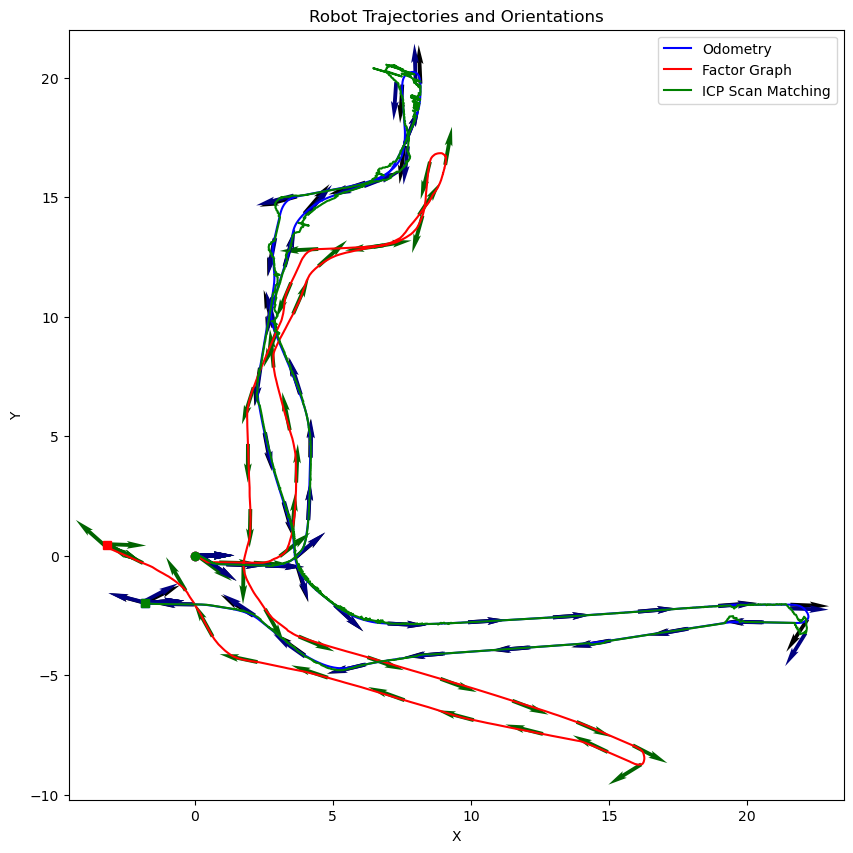

In [21]:
labels = [
    "Odometry",
    "Factor Graph",
    "ICP Scan Matching",
]
plot_N_trajectories([poses_odom, optimized_poses, poses_scan_matching], labels=labels)

In [22]:
#----------------------------------------------------------------------------
# Build occupancy grid map
# access map with ogm.grid_map, access log odd map with ogm.grid_map_log_odds
res = 0.05
ogm = OccupancyGridMap(res, 30., 30., -30., -30.)
ogm.build_map(optimized_poses, z_ts)
#----------------------------------------------------------------------------

Building the map...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4956/4956 [06:39<00:00, 12.41it/s]


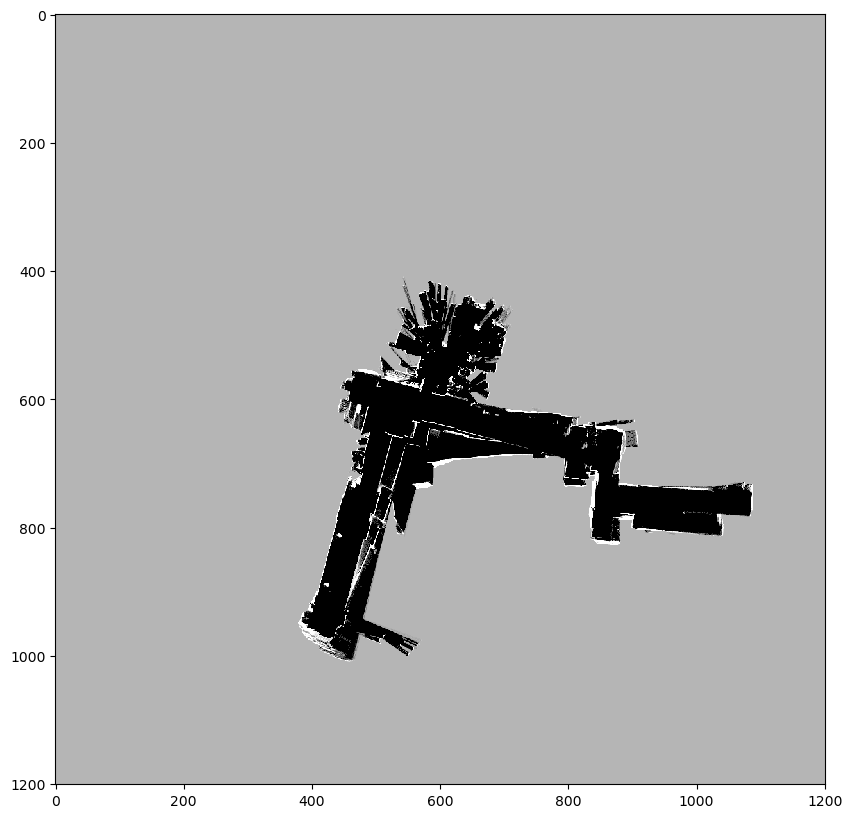

In [23]:
ogm.plot_log_odds_map()

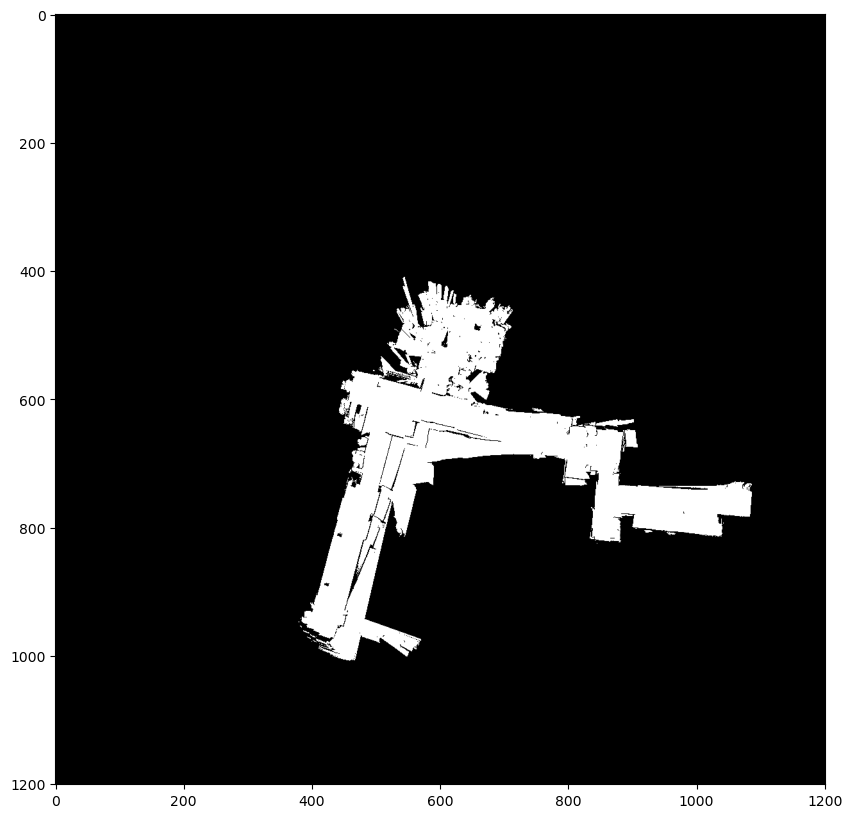

In [24]:
ogm.plot_map()

In [25]:
# Transformation from camera frame to robot's body frame (obtained from CAD)
p_rc = np.array([0.16766, 0., 0.38001])
R_rc = np.array([
    [ np.cos(rd(18.)), 0, np.sin(rd(18.))],
    [               0, 1,               0],
    [-np.sin(rd(18.)), 0, np.cos(rd(18.))]
])
T_rc = np.eye(4)
T_rc[:3, :3]  = R_rc
T_rc[:3,  3]  = p_rc

# Camera's intrinsic matrix
K = np.array([
    [585.05,      0, 242.94],
    [     0, 585.05, 315.84],
    [     0,      0,      1]
])

texture_map = generate_texture_map(
    dataset_num,
    optimized_poses,
    kinect,
    encoder,
    ogm,
    T_rc,
    K
)

Generating texture map...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2289/2289 [06:57<00:00,  5.48it/s]


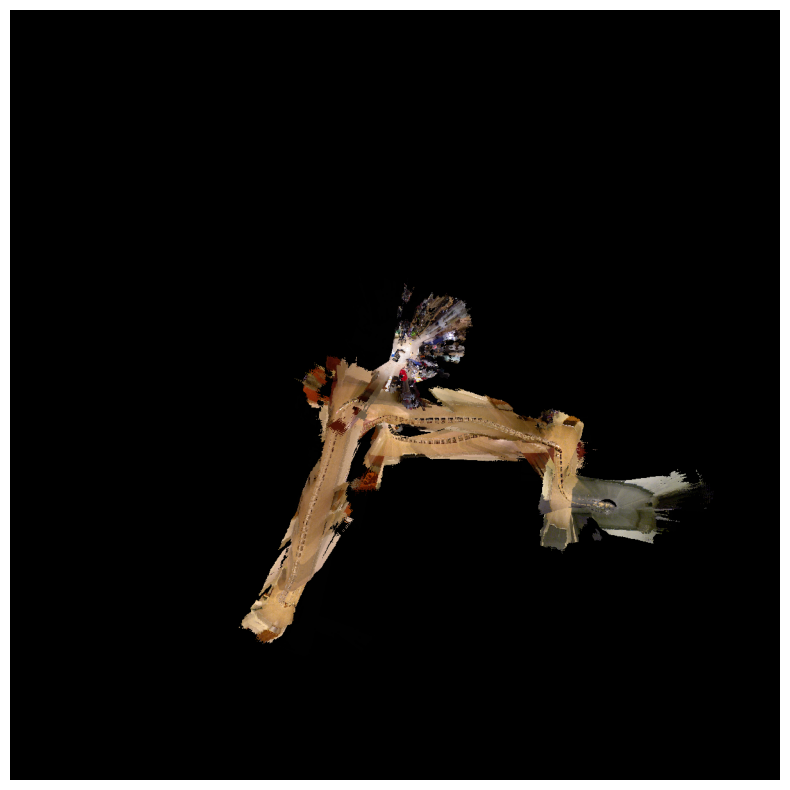

In [26]:
plot_texture_map(texture_map)